In [ ]:
!pip install imageio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
import seaborn as sns
from IPython import display

import imageio 
import time
from tensorflow.keras import layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#Importing data
data_path = "/content/drive/MyDrive/Data_science/abstract-art-gallery/Abstract_gallery/Abstract_gallery"
batch_s = 128
#Import as tf.Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_path, label_mode = None, image_size = (64,64), batch_size = batch_s)

Found 2782 files belonging to 1 classes.


Visualizing some of the pics

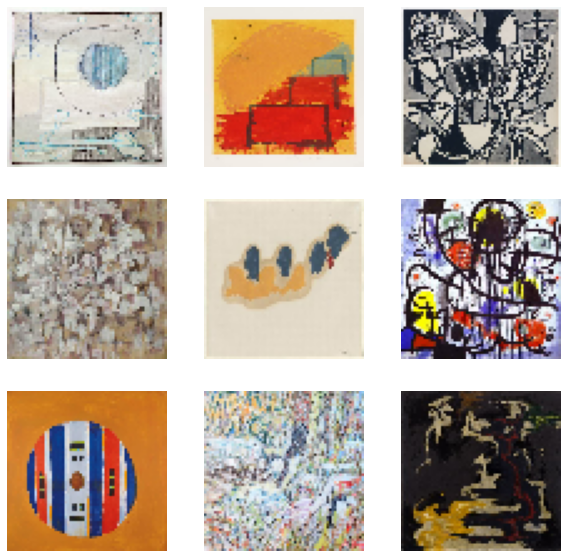

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    
    plt.axis("off")

Normalizing to [-1, 1]

In [ ]:
for image_batch in train_ds:
  print(image_batch.shape)
  break

(128, 64, 64, 3)


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./127.5, offset=-1)
normalized_ds = train_ds.map(lambda t: normalization_layer(t))

In [ ]:
image_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

-0.9921798 1.0


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
normalized_ds = normalized_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Generator

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((4, 4, 1024)))

    assert model.output_shape == (None, 4, 4, 1024)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(512, (5, 5), strides=2, padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=2, padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())


    model.add(layers.Conv2DTranspose(128, (5, 5), strides=2, padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)
    model.add(layers.Activation("tanh"))
    
    return model

testing the generator

# Discriminator

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, kernel_size=5, strides=2, input_shape=(64,64,3), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.GaussianNoise(0.1)) ###########
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128, kernel_size=5, strides=2, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(256, kernel_size=5, strides=2, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(512, kernel_size=5, strides=1, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.2))


    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="sigmoid"))

    return model

# GAN model

In [ ]:
class GAN:
  def __init__(self):
    self.discriminator = make_discriminator_model()
    self.generator = make_generator_model()

    self.cross_entropy = tf.keras.losses.BinaryCrossentropy() 

    self.generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.4)
    self.discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.4)
    self.batch_size = 128
    self.noise_dim = 100

    self.checkpoint_dir = './training_checkpoints'
    self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "ckpt")
    self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
                                    discriminator_optimizer=self.discriminator_optimizer,
                                    generator=self.generator,
                                 discriminator=self.discriminator)
    
    # print(self.discriminator.summary())
    # print(self.generator.summary())
  
  def discriminator_loss(self, real_output, fake_output):
    real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

  def generator_loss(self, fake_output):
    return self.cross_entropy(tf.ones_like(fake_output), fake_output)

  @tf.function # Compiles a function into a callable TensorFlow graph
  def train_step(self, images):
      noise = tf.random.normal([self.batch_size, self.noise_dim])

      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = self.generator(noise, training=True)

        real_output = self.discriminator(images, training=True)
        fake_output = self.discriminator(generated_images, training=True)

        gen_loss = self.generator_loss(fake_output)
        disc_loss = self.discriminator_loss(real_output, fake_output)

      
      gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

      self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
      self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

      return gen_loss, disc_loss

  def train(self, dataset, epochs, print_seed):
    gen_mean_history = []
    disc_mean_history = []

    gen_mean_object = tf.metrics.Mean()
    disc_mean_object = tf.metrics.Mean()

    for epoch in range(epochs):
      start = time.time()
      for image_batch in dataset:
        gen_loss, disc_loss = self.train_step(image_batch)

        gen_mean_object.update_state(gen_loss)
        disc_mean_object.update_state(disc_loss)
      
      gen_mean_history.append(gen_mean_object.result().numpy())
      disc_mean_history.append(disc_mean_object.result().numpy())

      gen_mean_object.reset_state()
      disc_mean_object.reset_state()
      
      # Produce images for the GIF as you go
      display.clear_output(wait=True)
      self.generate_and_save_images(
                              epoch + 1,
                              print_seed)
      
      print("epoch = {}".format(epoch+1))
      print('generator mean loss = {} '.format(gen_mean_history[epoch]))
      print('discriminator mean loss = {} '.format(disc_mean_history[epoch]))
      

      # Save the model every 15 epochs

      if (epoch + 1) % 15 == 0:
        self.checkpoint.save(file_prefix = self.checkpoint_prefix)

      print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)

    self.generate_and_save_images(
                            epochs,
                            print_seed)
    
    return gen_mean_history, disc_mean_history
    
  def generate_and_save_images(self, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = self.generator(test_input, training=False)

    fig = plt.figure(figsize=(10, 10))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] * 127.5 + 127.5).numpy().astype(np.uint8))
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

  


In [ ]:
EPOCHS = 450
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)

print_seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
gan_model = GAN()

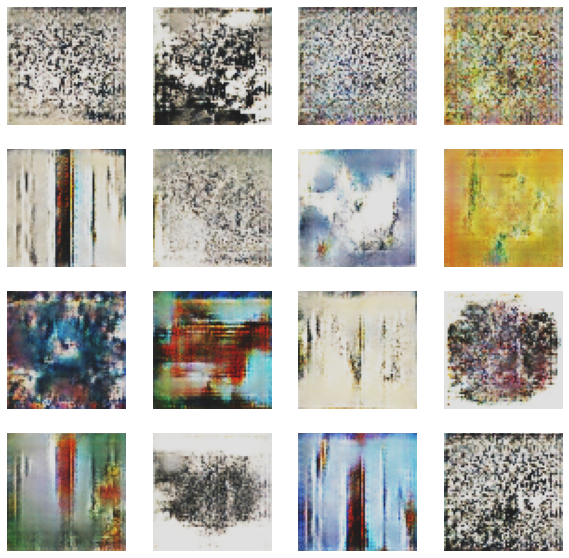

In [ ]:

gen_mean_history, disc_mean_history = gan_model.train(normalized_ds, EPOCHS, print_seed)

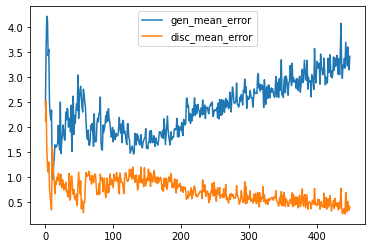

In [ ]:
plt.figure()
plt.plot(gen_mean_history)
plt.plot(disc_mean_history)
plt.legend(("gen_mean_error", "disc_mean_error"))
plt.show()

In [ ]:
# from google.colab import files
# os.system( "zip -r {} {}".format("ckpt-9.zip", "/content/training_checkpoints/ckpt-9.data-00000-of-00001"))
# files.download("ckpt-9.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Wasserstein Loss